In [3]:
import numpy as np
from fish.ephys import ephys
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('presentation')
from skimage import io
import os
import pandas as pd
%matplotlib inline

In [4]:
def prepare_swim(swims, threshold=False):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance, estimate_threshold
    from skimage.exposure import rescale_intensity
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[0] for s in swims]        
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts = rescale_intensity(ts, out_range=(0,1))
    
    if threshold:
        th = estimate_threshold(ts)
        ts[ts < th] = 0
    
    return ts

def prepare_data(fname, meta, do_threshold=True, fs_ep=6000, fused_roi=True):
    # load and process ephys data    
    from fish.ephys.ephys import load, chop_trials, windowed_variance
    from scipy.signal import fftconvolve, gaussian
    from numpy import array
    processed = {}
    dat = load(fname, memmap=True)
    swims = dat[0:2].copy()
        
    swims = array([windowed_variance(s)[0] for s in swims])
    laser_signal = dat[6].copy()
    trial_signal = dat[4].copy()
    
    swim_pow = prepare_swim(swims[meta['ch']], threshold=do_threshold)    
    
    kern_smooth = gaussian(2 * fs_ep, 1000)
    kern_smooth /= kern_smooth.sum()
    swim_pow_smooth = fftconvolve(swim_pow, kern_smooth, mode='same')
    processed['fname'] = fname
    processed['laser_signal'] = laser_signal
    processed['trial_signal'] = trial_signal
    processed['swims'] = swims
    processed['swim_power'] = swim_pow
    processed['swim_power_smoothed'] = swim_pow_smooth
        
    laser = chop_trials(laser_signal)
    on_val = max(list(laser.keys()))

    if fused_roi:
        for val in np.arange(2, len(np.unique(trial_signal)), 2):
            trial_signal[trial_signal == val] = val-1
        
    rois = chop_trials(trial_signal)
    conds = [int(x) for x in rois if x > 0]
    processed['stim_dur'] = np.median(rois[1][1] - rois[1][0])
    processed['conds'] = conds
    processed['trials'] = rois

    return processed

In [5]:
pos_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/'
neg_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/neg/'
rejected_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/rejected_data/'
proc_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/'

In [6]:
# 'ch' : [0,1] means use channels 0 and 1; 'ch : [0,0] means use 2 copies of channel 0;
exp_params = {}
exp_params['20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR'] = [0,0]
exp_params['20170320_2_6_g1_r1_7dpf_laser65'] = [0,1]
exp_params['20170321_1_3_g1_r1_6dpf_laser65_20ms'] = [0,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f1_omr_opto_2'] = [1,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f2_omr_opto_1'] = [0,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f3_omr_opto_2'] = [0,1]
exp_params['20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1'] = [0,0]
exp_params['20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6'] = [0,1]
exp_params['20170331_f1_g1_7dpf_6'] = [1,1]
exp_params['20170404_6dpf_cy252xcy293_f1_g1_omr_opto_1'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f4_g1_omr_opto_1'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f5_g1_omr_opto_2'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f6_g1_omr_opto_2'] = [0,1]
exp_params['20170405_7dpf_cy252xcy293_f1_g1_omr_opto_1'] = [0,1]
exp_params['20170405_7dpf_cy252xcy293_f2_g1_omr_opto_1'] = [0,1]
exp_params['20170319_1_1_g0_r0_6dpf'] = [1,1]
exp_params['20170319_2_2_g0_r0_6dpf_laser6'] = [1,0]
exp_params['20170322_7dpf_cy252xcy293_g0_f3_omr_opto_2'] = [1,1]
exp_params['20170406_6dpf_cy252xcy293_f1_g0_omr_opto_1'] = [0,1]
exp_params['20170419_5dpf_cy252xcy293_f3_g0_omr_opto_1'] = [0,1]

In [7]:
# Load raw data into dataframe
fnames = []

for fn in sorted(glob(proc_dir + 'pos/*/*.10chFlt')):
    exp_name = fn.split(os.path.sep)[-1].split('.')[0]
    genotype = 'pos'
    fnames.append(dict(path=fn, genotype=genotype, exp_name=exp_name, channels=exp_params[exp_name], data=ephys.load(fn, memmap=True)))

for fn in sorted(glob(proc_dir + 'neg/*/*.10chFlt')):
    exp_name = fn.split(os.path.sep)[-1].split('.')[0]
    genotype = 'neg'
    fnames.append(dict(path=fn, genotype=genotype, exp_name=exp_name, channels=exp_params[exp_name], data=ephys.load(fn, memmap=True)))

df = pd.DataFrame(fnames, index=list(map(lambda v: v['exp_name'], fnames)))

Data needed to be truncated!
Data needed to be truncated!


In [8]:
def prp_data(data, fs_ep = 6000, fused_roi = True, threshold=True, channels=[0,1]):
    from fish.ephys.ephys import chop_trials, windowed_variance
    from scipy.signal import fftconvolve, gaussian
    from numpy import array
    processed = {}
    
    swims = data[0:2].copy()        
    laser_signal = data[6].copy()
    trial_signal = data[4].copy()
        
    swim_pow = prepare_swim(swims[channels], threshold=threshold)    
    
    kern_smooth = gaussian(6 * fs_ep, 1 * fs_ep)
    kern_smooth /= kern_smooth.sum()
    swim_pow_smooth = fftconvolve(swim_pow, kern_smooth, mode='same')
     
    processed['laser_signal'] = laser_signal
    processed['trial_signal'] = trial_signal
    processed['swims'] = swims
    processed['swim_power'] = swim_pow
    processed['swim_power_smoothed'] = swim_pow_smooth
    
    laser = chop_trials(laser_signal)
    on_val = max(list(laser.keys()))

    if fused_roi:
        for val in np.arange(2, len(np.unique(trial_signal)), 2):
            trial_signal[trial_signal == val] = val-1
        
    rois = chop_trials(trial_signal)
    rois.pop(0.0)
    conds = [int(x) for x in rois]
    processed['stim_dur'] = np.median(rois[1][1] - rois[1][0])
    processed['conds'] = conds
    processed['trials'] = rois

    return processed

In [9]:
%%time
# only consider trials falling between (2 minutes, 20 minutes) after experiment start
ep_window = slice(0, 6000 * 1210)
prepped = [prp_data(df.loc[x]['data'][:,ep_window], channels=df.loc[[x]]['channels']) for x in df.index]

CPU times: user 1min 3s, sys: 10 s, total: 1min 13s
Wall time: 1min 13s


In [10]:
prepped_df = pd.DataFrame(prepped, index=df.index)
prepped_df['genotype'] = df['genotype']

In [11]:
# Generate trial averages for each fish

fs_ep = 6000
ds_ep = 1
window = np.arange(-fs_ep * 5, fs_ep * 15, ds_ep)

def trial_window(data, condition, window):    
    trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
    return data['swim_power_smoothed'][trials]
   
tr_means = {}
genotypes = ['pos', 'neg']
conditions = [1.0, 3.0]
for g in genotypes:
    tr_means[g] = {}
    for c in conditions:
        tr_means[g][c] = {}
        tr_means[g][c] = np.array([np.median(trial_window(data[1], c, window),0) for data in prepped_df[prepped_df.genotype==g].iterrows()]).T;
        stim = np.where(window > 0)[0][0]
        tr_means[g][c] /= tr_means[g][c][:stim,:].mean(0);

tr_means = pd.DataFrame(tr_means)

In [12]:
powers = []
conds = [1.0, 3.0]
wl = 18000
offset = 0
for ind in prepped_df.index:
    exp = prepped_df.loc[ind]
    powers_ = {}
    for c in conds:
        powers_[c] = {}
        powers_[c]['pre'] = np.array([exp['swim_power'][slice(x - wl, x)].mean() for x in exp['trials'][c][0]])
        powers_[c]['post'] = np.array([exp['swim_power'][slice(x+offset, x + wl+offset)].mean() for x in exp['trials'][c][1]])
    powers.append(powers_)
powers = pd.DataFrame(powers, index=prepped_df.index)
powers['genotype'] = prepped_df['genotype']

In [13]:
pooled_powers = {}
genotypes = ['pos', 'neg']
conditions = [1.0, 3.0]
epochs = ['pre', 'post']
for g in genotypes:
    pooled_powers[g] = {}
    for c in conditions:
        pooled_powers[g][c] = {}
        for ep in epochs:
            pooled_powers[g][c][ep] = []
            [pooled_powers[g][c][ep].extend(p[ep]) for p in powers[prepped_df['genotype'] == g][c]]

pooled_powers = pd.DataFrame(pooled_powers)

## Show power per fish before and after stimulation, compute a p-value comparing change in mean of the distribution before and after stimulation

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


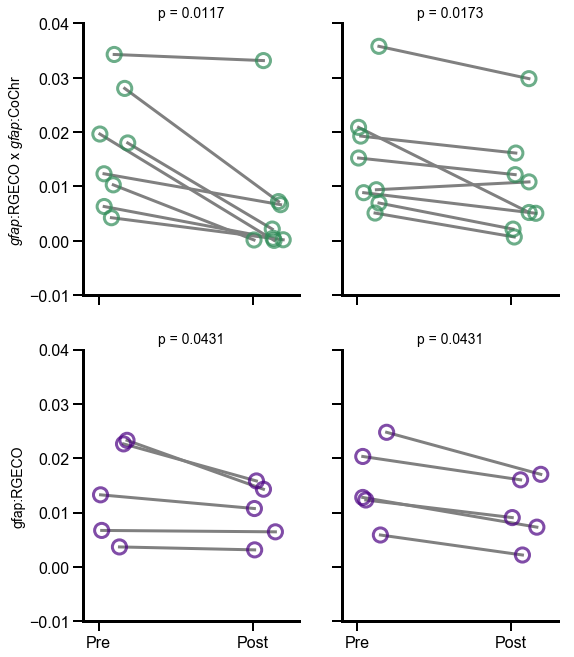

In [14]:
from scipy.stats import wilcoxon
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(8.5,11), sharey=True, sharex=True)
pre_post = {}
gens = ['pos', 'neg']
conds = [1.0, 3.0]
colors = ['seagreen', 'indigo']
axs_titles = ['$gfap$:RGECO x $gfap$:CoChr', 'gfap:RGECO']
jit_std = .2
jit_shift = 1
for ind_g, g in enumerate(gens):
    for ind_c, c in enumerate(conds):
        pre_post[g] = [(np.median(x['pre']), np.median(x['post'])) for x in powers[powers['genotype'] == g][c]]
        pp = list(zip(*pre_post[g]))
        sig = wilcoxon(pp[0], pp[1]).pvalue
        jit = [np.random.random(len(pre_post[g])) * jit_std, jit_shift + np.random.random(len(pre_post[g])) * jit_std]
        ax = axs[ind_g][ind_c]
        ax.scatter(jit[0], pp[0], edgecolors=colors[ind_g], s=200, alpha=.7, facecolors='none', linewidth=3)
        ax.scatter(jit[1], pp[1], edgecolors=colors[ind_g], s=200, alpha=.7, marker='o', facecolors='none', linewidth=3)
        ax.plot(jit, pp, color=(.5,.5,.5), zorder=0, linewidth=3)
        ax.set_title('p = {0}'.format(np.round(sig, 4)), fontsize=14)
        ax.set_xticks([0,1])
        ax.set_xticklabels(['Pre','Post'])
        ax.set_ylim(-.01, .04)

axs[0][0].set_ylabel(axs_titles[0], fontsize=14)
axs[1][0].set_ylabel(axs_titles[1], fontsize=14)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_statistics.pdf')

## double-distribution plot

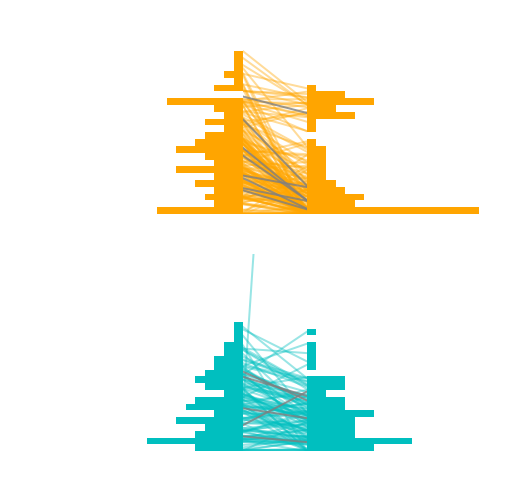

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,8), sharey='row', gridspec_kw = dict(width_ratios=(3,1,3)))
axs[0][0].invert_xaxis()
axs[1][0].invert_xaxis()
plt.subplots_adjust(wspace = 0)
conds = [1.0]
colors = {'neg' : 'c', 'pos' : 'orange'}
for idx, ind in enumerate(prepped_df.index):
    gen = df.loc[ind]['genotype']
    row = axs[0]

    if  gen == 'neg':
        row = axs[1]    
    
    exp = prepped_df.loc[ind]          
    powr = powers.loc[ind] 
    for c in conds:
        x = [np.zeros(len(powr.loc[c]['pre'])),1 + np.zeros(len(powr.loc[c]['pre']))]
        y = [powr.loc[c]['pre'], powr.loc[c]['post']]
        row[1].plot(x, y, alpha=.4, color=colors[gen], linewidth=2)
        row[1].plot(list(map(np.mean, x)), list(map(np.mean, y)), alpha=.8, color=[.5,.5,.5], linewidth=2, zorder=200)
    row[1].set_ylim(0, .06)
    row[1].set_xlim(0, 1)
    row[1].axis('off')
    row[0].axis('off')
    row[-1].axis('off')
    row[0].hist(powr.loc[c]['pre'][~np.isnan(powr.loc[c]['pre'])], np.linspace(0, .06, 30), orientation='horizontal', color=colors[gen])    
    row[-1].hist(powr.loc[c]['post'][~np.isnan(powr.loc[c]['post'])], np.linspace(0, .06, 30), orientation='horizontal', color=colors[gen])
    
    row[0].set_xlim((20, 0))
    row[-1].set_xlim((0, 20))

In [16]:
def raster_plot(data, fs_ep=6000):  
    to_compare = [1,3]
    fig, axs = plt.subplots(nrows=2 + len(to_compare), figsize=(8,12))
    ds_ep = 100
    window = np.arange(-fs_ep * 10, fs_ep * 15, ds_ep)
    onset = np.where(window >= 0)[0][0]
    
    axs[0].plot(data['swims'][0][::15], alpha=.7)
    axs[0].plot(-data['swims'][1][::15], alpha=.7)
    axs[0].axis('tight')    
    
    
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        to_plot = data['swim_power_smoothed'][trials]                            
        tr_mean = to_plot.mean(0)
        # rescale pre-stimulus swims to mean = 1
        #tr_mean /= tr_mean[:onset].mean()        
        clims = (to_plot.min(), to_plot.max())
        # plot the whole recording, both channels        
        axs[1 + ind].imshow(to_plot, cmap='jet', interpolation='None', extent=(window[0] / fs_ep, window[-1] / fs_ep, to_plot.shape[0], 0), aspect='auto', clim=clims)
        axs[1 + ind].set_ylabel('ROI {0}'.format(condition))    
        
        axs[-1].plot(window/ fs_ep, tr_mean)
        axs[-1].axis('tight')
        
    return axs

In [ ]:
for exp in prepped_df.index:
    axs = raster_plot(prepped_df.loc[exp])
    axs[0].title.set_text(exp)

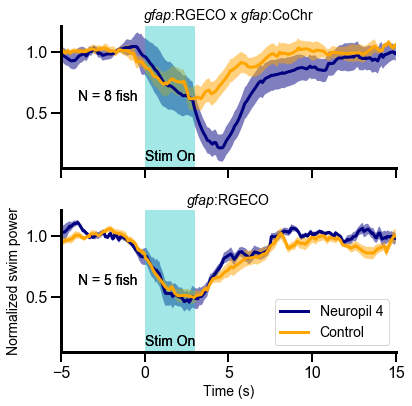

In [25]:
from scipy.stats import sem
fontsize = 14
conds = [1.0, 3.0]
axs_titles = ['$gfap$:RGECO x $gfap$:CoChr', '$gfap$:RGECO']
gens = ['pos', 'neg']
colors = {1.0 : 'navy', 3.0 : 'orange'}
cond_titles = {1.0 : 'Neuropil 4', 3.0 : 'Control'}
fig, axs = plt.subplots(nrows=2, figsize=(6,6), sharey=True, sharex=True)
ds = 10
x_axis = window[::ds] / fs_ep

for ind_g, g in enumerate(gens):    
    for ind_c, c in enumerate(conds):
        cur_axs = axs[ind_g]        
        av = np.median(tr_means[g][c],1)[::ds]        
        err = sem(tr_means[g][c], 1)[::ds]
        err_bounds = (av - err, av + err)
        
        pts_x = np.hstack([x_axis[::-1], x_axis])
        pts_y = np.hstack([err_bounds[0][::-1], err_bounds[1]])
        
        cur_axs.plot(x_axis, av, linewidth=3, color=colors[c], label=cond_titles[c])                
        cur_axs.fill_between(x_axis, *err_bounds, facecolor=colors[c], alpha=.5, edgecolor=None)
        cur_axs.set_xlim((x_axis[0],x_axis[-1]))
        cur_axs.axvspan(0,3, color='c', alpha=.2, linewidth=0)        
        cur_axs.text(-4, .6, 'N = {0} fish'.format(tr_means[g][c].shape[1]), fontsize=fontsize)
        cur_axs.text(0, .1, 'Stim On', fontsize=fontsize)
        cur_axs.title.set_text(axs_titles[ind_g])
        cur_axs.title.set_fontsize(fontsize)
        cur_axs.set_xticks(range(-5, 20, 5))
        

axs[-1].set_xlabel('Time (s)', fontsize=fontsize)
axs[-1].set_ylabel('Normalized swim power', fontsize=fontsize)
axs[-1].legend(fontsize=fontsize)
plt.subplots_adjust(hspace=0.3)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_group_timeseries.pdf')